# Doc2Vec

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.
`Doc2vec is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents.  Distributed Representations of Sentences and Documents . The algorithm is an adaptation of word2vec which can generate vectors for words.`

Doc2vec is that we need to run gradient descent during prediction to infer the vector for an unseen document. An unseen document is initially assigned a random vector and then this vector fit by gradient descent. Because of this randomness we get different vectors on re-runs of the next cell.



### Requirements:
1. Python 3
2. gensim==3.8.1
3. sklearn
4. pandas==0.24.0
5. matplotlib
6. nltk 
7. tqdm
8. numpy==1.16.2

### Dataset

Movie dataset(`tagged_plots_movielens.csv`) with fields :

1. MovieId
2. Plot
3. Tag

We have to classify Genre of movie plot.


### Model used

1. Logostic regression
2. Random Forest
3. KNN 


In [97]:
##Import Libraries for manipulating data
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import re
from nltk import word_tokenize
from nltk.corpus import stopwords

In [77]:
##Import Libraries for classification model building 
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
##Import Libraries for doc2vec model building
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [4]:
##Import Libraries for Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [99]:
##Load Data
dataset=pd.read_csv("tagged_plots_movielens.csv")
dataset.drop(columns=['Unnamed: 0'],inplace=True)
dataset.head()

,movieId,plot,tag
0,1,A little boy named Andy loves to be in his roo...,animation
1,2,When two kids find and play a magical board ga...,fantasy
2,3,Things don't seem to change much in Wabasha Co...,comedy
3,6,Hunters and their prey--Neil and his professio...,action
4,7,An ugly duckling having undergone a remarkable...,romance


In [100]:
##Data Info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 3 columns):
movieId    2448 non-null int64
plot       2427 non-null object
tag        2448 non-null object
dtypes: int64(1), object(2)
memory usage: 57.5+ KB


In [101]:
##Find if any null record is present
dataset['plot'].isnull().values.any()

True

In [102]:
##Count no of null records
dataset['plot'].isnull().sum()

21

In [103]:
##Delete Null records
dataset= dataset.dropna(how='any',axis=0)

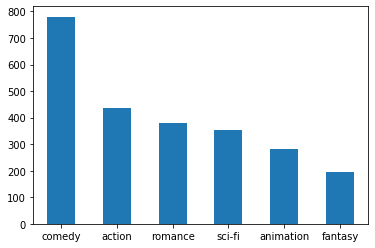

In [104]:
##Plotting Dataset
###### Check Distribution of different Classes 
tags = dataset.tag.unique()
dataset.tag.value_counts().plot(kind="bar", rot=0)

## Text Preprocessing

In [105]:
##Clean Data
def clean_text(doc):
    clean_text=re.sub("[^A-Za-z]", " ",doc)
    res_text="".join(clean_text.lower())
    return res_text
  

In [106]:
dataset['plot']=dataset['plot'].apply(lambda x: clean_text(x))


In [107]:
##Split data into Train test split
train_data,test_data = np.split(dataset.sample(frac=1), [int(.90*len(dataset))])

In [108]:
train_data.size,test_data.size

(6552, 729)

In [109]:
train_data=train_data.reset_index(drop=True)
train_data.head()

,movieId,plot,tag
0,59709,martin a phd student in mathematics enrolls ...,romance
1,41769,a dramatic comedy inspired by the lives of tw...,romance
2,117176,the theory of everything is the story of the m...,romance
3,5235,in a futuristic london the rising sea levels ...,sci-fi
4,77364,a cia special forces team are betrayed and lef...,comedy


In [110]:
test_data=test_data.reset_index(drop=True)
test_data.tail()

,movieId,plot,tag
238,7387,following the events of night of the living de...,action
239,90154,troubled divorcee mary kee is tormented by a s...,romance
240,78209,english rock star aldous snow relapses into dr...,comedy
241,2289,a studio script screener gets on the bad side ...,comedy
242,1480,based on peter hoeg s bestseller this film is...,sci-fi


In [111]:
# def tokenize_text(doc):
#     return word_tokenize(doc)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [112]:
train_data = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]),axis=1)

In [113]:
test_data = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]),axis=1)

In [114]:
import multiprocessing
cores = multiprocessing.cpu_count()

## Doc2Vec Model

In [115]:
##Model Building

modelDoc = Doc2Vec(size=300, window=5, dm=1, dbow_words=1, hs=0, negative=10, alpha=0.05, min_count=20,
                            sample=1e-5, seed=0, iter=10)
##Build Vocab
modelDoc.build_vocab([x for x in tqdm(train_data.values)])

/opt/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/opt/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 2184/2184 [00:00<00:00, 1303038.40it/s]


In [116]:
%%time
for epoch in range(30):
    modelDoc.train(utils.shuffle([x for x in tqdm(train_data.values)]), total_examples=len(train_data.values), epochs=1)
    modelDoc.alpha -= 0.002
    modelDoc.min_alpha = modelDoc.alpha

100%|██████████| 2184/2184 [00:00<00:00, 3198449.70it/s]


CPU times: user 2.83 s, sys: 652 ms, total: 3.49 s
Wall time: 2.42 s


In [117]:
import random
seed = 10

modelDoc.seed = seed
modelDoc.random = np.random.RandomState(seed)
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

    

In [118]:
y_train, X_train = vec_for_learning(modelDoc, train_data)
y_test, X_test = vec_for_learning(modelDoc, test_data)


## Logistic Regression

In [119]:
log_reg = LogisticRegression(n_jobs=1, C=1e5,random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.38271604938271603
Testing F1 score: 0.3725995645947657


## Random Forest

In [120]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.411522633744856
Testing F1 score: 0.3607040722775264


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## KNN Classifier

In [121]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.35390946502057613
Testing F1 score: 0.33715979510090366


In [122]:
modelDoc.most_similar([modelDoc.docvecs['sci-fi']])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('earth', 0.9768292903900146),
 ('planet', 0.9689270257949829),
 ('government', 0.965299665927887),
 ('military', 0.9649670124053955),
 ('humanity', 0.9649150371551514),
 ('survivors', 0.9631949067115784),
 ('space', 0.9630962610244751),
 ('evil', 0.9624673128128052),
 ('distant', 0.9622239470481873),
 ('captain', 0.9622179269790649)]

### Conclusion:

Random Forest classifier gives the best result!!!

For improving scores:
    1. Introduce stopwords while cleaning text
    2. Using dm=1 while building doc2vec instance creation